In [2]:
# Import packages
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pylab
import mahotas as mh
import cv2

In [3]:
from Functions import create_dirs, check_sky, mask_seg, count_animals, smooth_animals, plot_image, get_centers_through_borders, get_bboxes, write_file

In [4]:
bad_image_list = []

# image height = 60 (2019-10)
# image height = 30 (2019-11)
sigma = 2
minimum_animal_size = 10
kernel = (5,5)
date = "2019-11"

input_location = "../Data/images/" + date + "/"
input_location_s = "../Data/semantic/" + date + "/"
output_location = "../Data/labels/" + date + "/"


In [5]:
# Create the data directories
create_dirs(date)

Creation of the directory ../Data/images/2019-11 failed
Creation of the directory ../Data/labels/2019-11 failed
Creation of the directory ../Data/images/2019-11 failed


###----------###
IMG242_-20,-95.png
###----------###

This image contains 5 animals, including tiny blobs
This image contains 4 animals, excluding tiny blobs
Labeled blobs before erosion


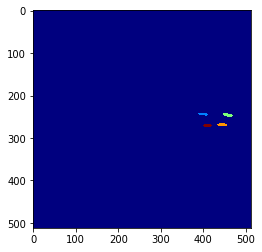

Labeled blobs after dilation


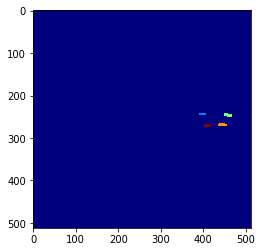

Real image


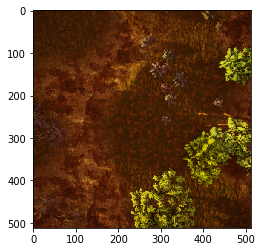

center locations: [(0.7763671875, 0.47563032670454547), (0.8935546875, 0.4811604817708333), (0.8671875, 0.525390625), (0.7994140625, 0.5284939236111111)] 

bboxes: [(0.03515625, 0.01171875), (0.0390625, 0.01953125), (0.041015625, 0.013671875), (0.03515625, 0.01171875)] 

Proper animals found: writing file 

###----------###
IMG289_115,10.png
###----------###

This image contains 6 animals, including tiny blobs
This image contains 3 animals, excluding tiny blobs
Labeled blobs before erosion


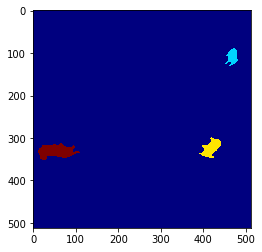

Labeled blobs after dilation


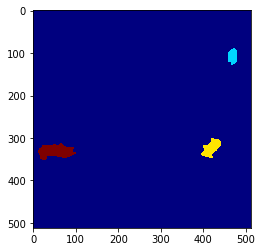

Real image


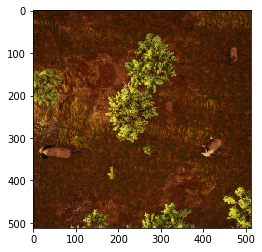

center locations: [(0.9143400493421052, 0.21415501644736842), (0.8152545797413793, 0.6327384159482758), (0.1095614346590909, 0.6482244318181818)] 

bboxes: [(0.044921875, 0.076171875), (0.091796875, 0.09375), (0.17578125, 0.076171875)] 

Proper animals found: writing file 

###----------###
IMG355_160,-110.png
###----------###

This image contains 4 animals, including tiny blobs
This image contains 1 animals, excluding tiny blobs
Labeled blobs before erosion


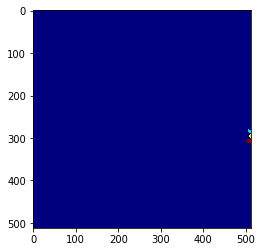

Labeled blobs after dilation


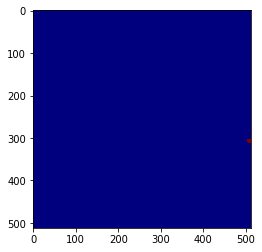

Real image


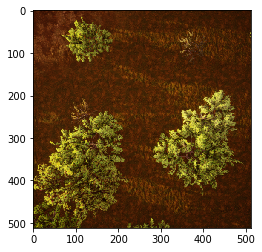

center locations: [(0.9869666466346154, 0.6002103365384616)] 

bboxes: [(0.01953125, 0.015625)] 

Proper animals found: writing file 

###----------###
IMG789_70,55.png
###----------###

This image contains 3 animals, including tiny blobs
This image contains 3 animals, excluding tiny blobs
Labeled blobs before erosion


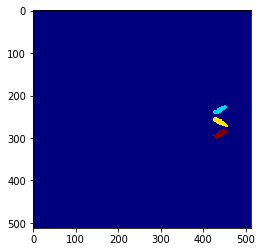

Labeled blobs after dilation


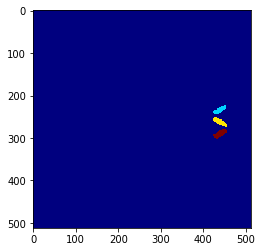

Real image


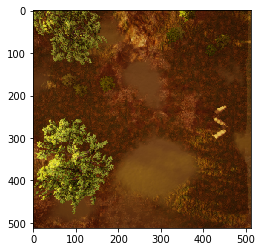

center locations: [(0.8556857638888888, 0.4571940104166667), (0.8564453125, 0.5125732421875), (0.8566300675675675, 0.5665118243243243)] 

bboxes: [(0.060546875, 0.041015625), (0.06640625, 0.04296875), (0.0625, 0.044921875)] 

Proper animals found: writing file 

###----------###
IMG790_85,70.png
###----------###

This image contains 3 animals, including tiny blobs
This image contains 3 animals, excluding tiny blobs
Labeled blobs before erosion


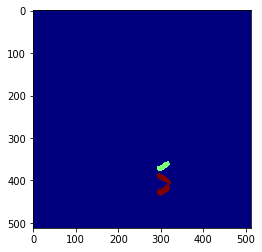

Labeled blobs after dilation


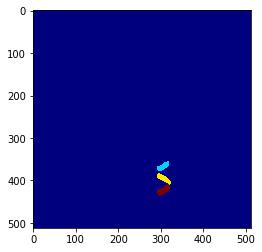

Real image


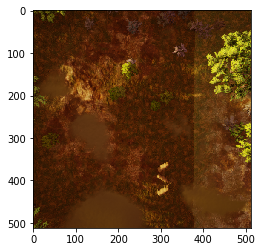

center locations: [(0.5971019847972973, 0.7151868665540541), (0.5999307753164557, 0.7740926621835443), (0.5981987847222222, 0.8239896797839507)] 

bboxes: [(0.0546875, 0.046875), (0.0625, 0.052734375), (0.056640625, 0.0546875)] 

Proper animals found: writing file 

###----------###
IMG802_265,250.png
###----------###

This image contains 0 animals, including tiny blobs
This image contains 0 animals, excluding tiny blobs
Zero animals in this picture, not adding file information to labels file 



In [6]:
with open("../Data/labels/00_SPLIT.txt","w") as file: 
    for image_name in os.listdir("../Data/semantic/" + date + "/test"): # + "/test"

        if image_name == "/test":
            continue
        # Input image from directory
        print("###----------###" + "\n" + image_name + "\n" + "###----------###" + "\n")
        input_image_s = input_location_s + image_name
        
        
        # If image contains sky, i.e. it's under the ground level, continue, else, write the file to the 00_SPLIT file
        if check_sky(input_image_s) == True:
            print("Warning, image contains sky. Removing from set.")
            bad_image_list.append(image_name)
            continue
        else:
            file.write(date + "/" + image_name + ' ' + "1") # The 1 refers to whether this is for training, test, or dev
            file.write("\n")
        
        
        # Mask everything but animals in image
        animals, mask = mask_seg(input_image_s)

        
        # Smooth animals with gaussian and remove tiny animals less than set size
        animals_smooth = smooth_animals(animals, sigma = sigma)

        
        # Count animals, if no animals are present, skip image
        labeled_animals, nr_objects = count_animals(animals_smooth, minimal_size = minimum_animal_size,image_kernel=kernel)
        if nr_objects == 0:
            print("Zero animals in this picture, not adding file information to labels file", "\n")
            continue
        else:
            plot_image(input_location + image_name)
        
        # Get centers of animals using boundaries
        centers_list = get_centers_through_borders(labeled_animals, nr_objects)
        
        
        # Get bboxes of animals in image
        #centers_list = get_centers(animals_smooth,clean_distance = clean_distance) # old
        bbox_list = get_bboxes(labeled_animals)

        
        # Output centers and bboxes
        write_file(output_location,image_name,centers_list,bbox_list)
        
        # 242 289 355 789 790

In [6]:

# Deletes images that have innapropriate compositions in them

print(bad_image_list)
for image in bad_image_list:
    try:
        os.remove(input_location + image)
        os.remove(input_location_s + image)
    except:
        print("File already removed")


[]


In [9]:
img_dir = os.listdir("../Data/images/2019-11/")
seg_dir = os.listdir("../Data/semantic/2019-11/")

In [47]:
def get_animal_dicts(img_dir, seg_dir):
    
    dataset_dicts_list = []
    img_list = os.listdir(img_dir)
    seg_list = os.listdir(seg_dir)
    
    for image in img_list[0:10]:
        
        
        image_dict = {}
#     file_name: the full path to the image file.
        image_dict["file_name"] = img_dir + image
    
#     sem_seg_file_name: the full path to the ground truth semantic segmentation file.
        image_dict["sem_seg_file_name"] = seg_dir + image

#     image: the image as a numpy array.
        image_dict["image"] = cv2.imread(img_dir + image)
    
#     sem_seg: semantic segmentation ground truth in a 2D numpy array. Values in the array represent category labels.
        image_dict["image"] = cv2.imread(seg_dir + image)
    
#     height, width: integer. The shape of image.
        image_dict["height"], image_dict["width"] = cv2.imread(img_dir + image).shape[:2]
    
#     image_id (str): a string to identify this image. Mainly used by certain datasets during evaluation to identify the image, but a dataset may use it for different purposes.
        image_dict["image_id"] = image[:-4]

#     annotations (list[dict]): the per-instance annotations of every instance in this image. Each annotation dict may contain:
        annotations = []

#     bbox (list[float]): list of 4 numbers representing the bounding box of the instance.
        

#     bbox_mode (int): the format of bbox. It must be a member of structures.BoxMode. Currently supports: BoxMode.XYXY_ABS, BoxMode.XYWH_ABS.

#     category_id (int): an integer in the range [0, num_categories) representing the category label. The value num_categories is reserved to represent the “background” category, if applicable.
    
        dataset_dicts_list.append(image_dict)
        print(dataset_dicts_list)
    #return list[dict]

#from detectron2.data import DatasetCatalog
#DatasetCatalog.register("my_dataset", get_dicts)

In [48]:
get_animal_dicts("../Data/images/2019-11/","../Data/semantic/2019-11/")

[{'file_name': '../Data/images/2019-11/IMG1000_-230,70.png', 'sem_seg_file_name': '../Data/semantic/2019-11/IMG1000_-230,70.png', 'image': array([[[ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232],
        ...,
        [ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232]],

       [[ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232],
        ...,
        [ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232]],

       [[ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232],
        ...,
        [ 80, 250, 232],
        [ 80, 250, 232],
        [ 80, 250, 232]],

       ...,

       [[ 39, 224,  95],
        [ 39, 224,  95],
        [ 39, 224,  95],
        ...,
        [ 39, 224,  95],
        [ 39, 224,  95],
        [ 39, 224,  95]],

       [[ 39, 224,  95],
        [ 39, 224,  95],
        [ 39, 224,  95],
        ...,
        [ 39, 224,  95],
        [ 39, 224,  95],
        [ 39, 224,  95]],

       [[ 39, 224,  95]